## Szintetikus regiszteradat-generálás  
*(English version below)*

Ez a notebook a repozitórium `README.md` fájljában hivatkozott szakdolgozat **„Szintetikus regiszteradat generálása”** című, **„A”** jelű mellékletében rögzített adatgenerálási specifikáció reprodukálható \textsf{R} megvalósítását mutatja be.

A generálás eredménye egy esetszintű, regiszterjellegű szintetikus adatállomány, ahol ugyanabban a táblában egyszerre szerepelnek  
(i) a megfigyelt, cenzorálást is tartalmazó regisztermezők (`F`, `delta`), valamint  
(ii) a cenzorálatlan eseményfolyamatot rögzítő referencia-mezők (`F_true`, `delta_true`).

### Kapcsolódás a specifikációhoz

Az adatgeneráló eljárás teljes implementációja a `notebooks/synthetic_registry_yearly.R` fájlban található. A notebook szerepe a script paraméterezett futtatása, majd az így előállított adat felhasználása a kiterjesztett (több indexdátumra értelmezett) Crouch-féle prevalenciabecslő eljárás becslési pontosságának vizsgálatához.

### Implementált komponensek (a specifikáció szerint)

1. **Időtengely és regiszterablak:** `t_orig` a választott origó dátum, `t_min` és `t_max` az incidenciagenerálás kezdő és záró dátuma, míg `t_end` a megfigyelési horizont vége.
2. **Éves incidenciafolyamat és diagnózisnapok:**
   - naptári évek szerinti bontás,
   - determinisztikus trend az éves várható intenzitásra  
     (`lambda_bar_y = lambda0 * (1+gamma)^(y-Y_min)`),
   - multiplikatív lognormális bizonytalanság (`U_y`),
   - éves esetszámok Poisson-modellből (`N_y`),
   - éven belüli diagnózisnapok diszkrét egyenletes mintavétele.
3. **Kovariánsok generálása:** hierarchikus séma (`X1`, `X2`, `X3`) Bernoulli/Beta/Normal komponensekkel.
4. **Latens eseményidő:** kovariánsfüggő generalizált gamma modellből (`T`; paraméterek: `gg_lam`, `gg_k`, `gg_b`, `gg_q`), nap pontosságú diszkretizálással.
5. **Referencia-mezők képzése:** `F_true`, `delta_true`.
6. **Megfigyelési mechanizmus:**
   - adminisztratív cenzorálás,
   - véletlen LTFU-cenzorálás,
   - megfigyelt mezők képzése (`F`, `delta`).
7. **Végső esetszintű tábla:** egységes, emberi olvashatóságot támogató oszlopnév-konvencióval.

### Notebook felépítése

1. A kezdő kódcella betölti a szükséges környezetet, majd importálja az adatgeneráló scriptet  
   (`source("../R/synthetic_registry_yearly.R")`).
2. A következő kódcella egy rögzített paraméterezés mellett legenerálja a szintetikus adatállományt (`synthetic_registry`).
3. A záró kódcella egy megadott indexdátumra prevalenciaszámításokat végez külön
   a referencia-mezők, illetve külön a megfigyelt (cenzorált) mezők alapján.

---
*(English version)*
## Synthetic Registry Data Generation  

This notebook presents a reproducible **R** implementation of the data-generating specification documented in Appendix **“A”**, titled **“Synthetic Registry Data Generation”**, of the thesis referenced in the repository’s `README.md` file.

The output of the generation procedure is an individual-level, registry-style synthetic dataset in which the same table simultaneously contains  
(i) the observed registry fields including censoring (`F`, `delta`), and  
(ii) the reference fields describing the uncensored event process (`F_true`, `delta_true`).

### Relation to the Specification

The complete implementation of the data-generating procedure is provided in the file `notebooks/synthetic_registry_yearly.R`.  
The role of this notebook is to execute the script with a fixed parameterization and subsequently use the generated dataset to evaluate the estimation accuracy of the extended (multi-index-date) Crouch-type prevalence estimator.

### Implemented Components (According to the Specification)

1. **Time axis and registry window:** `t_orig` denotes the chosen origin date; `t_min` and `t_max` define the start and end of incidence generation, while `t_end` marks the end of the observation horizon.  

2. **Annual incidence process and diagnosis dates:**
   - calendar-year decomposition,  
   - deterministic trend in the expected annual intensity  
     (`lambda_bar_y = lambda0 * (1+gamma)^(y - Y_min)`),  
   - multiplicative lognormal uncertainty (`U_y`),  
   - annual case counts from a Poisson model (`N_y`),  
   - within-year diagnosis dates sampled from a discrete uniform distribution.  

3. **Covariate generation:** hierarchical scheme (`X1`, `X2`, `X3`) using Bernoulli, Beta, and Normal components.  

4. **Latent event time:** covariate-dependent generalized gamma model (`T`; parameters: `gg_lam`, `gg_k`, `gg_b`, `gg_q`), discretized to daily resolution.  

5. **Construction of reference fields:** `F_true`, `delta_true`.  

6. **Observation mechanism:**
   - administrative censoring,  
   - random LTFU censoring,  
   - construction of observed fields (`F`, `delta`).  

7. **Final individual-level table:** unified column naming convention supporting human readability.  

### Structure of the Notebook

1. The first code cell loads the required environment and imports the data-generating script  
   (`source("../R/synthetic_registry_yearly.R")`).  

2. The next code cell generates the synthetic dataset (`synthetic_registry`) under a fixed parameterization.  

3. The final code cell performs prevalence calculations at a specified index date separately  
   based on the reference fields and on the observed (censored) fields.


<!-- AUTO: commentary -->

**Betoltes.** Betolti a lokalis (forkolt) csomagkodot es a szintetikus generalashoz tartozo segedfuggvenyeket.
A kiirt utvonalnak a repo gyokerere kell mutatnia; ha nem, akkor nem a megfelelo kod fut.


In [75]:
options(stringsAsFactors = FALSE)

project_root <- if (file.exists("DESCRIPTION")) {
  "."
} else if (file.exists("../DESCRIPTION")) {
  ".."
} else {
  stop("Could not find project root (DESCRIPTION).")
}

if (!requireNamespace("devtools", quietly = TRUE)) {
  stop("Please install devtools to load the local package.")
}

suppressPackageStartupMessages(devtools::load_all(project_root, quiet = TRUE))

loaded_path <- normalizePath(getNamespaceInfo("rprev", "path"), winslash = "/")
expected_path <- normalizePath(project_root, winslash = "/")
if (loaded_path != expected_path) {
  stop("Loaded rprev is not the local repo version: ", loaded_path)
}
cat("Loaded local fork (package name: rprev) from: ", loaded_path, "\n", sep = "")

source(file.path(project_root, "notebooks", "synthetic_registry_yearly.R"))


Loaded local fork (package name: rprev) from: C:/Users/600972868/OneDrive - BT Plc/Desktop/Sajat Mappa/00 - BGE/Alkalmazott Matematika/Szakdolgozat/repo/rprev-ext


<!-- AUTO: commentary -->

**Reprodukcio (git meta).** Kiolvassa es kiirja a jelenlegi git branch es commit azonositot.
Ezt hasznald az eredmenyek visszakovethetosegere (ha `NA`, akkor a git nem elerheto a kernelbol).


In [76]:
# --- Git meta (branch + commit) kiirasa ---
git_cmd <- function(cmd) {
  out <- tryCatch(
    system(cmd, intern = TRUE, ignore.stderr = TRUE),
    error = function(e) character(0)
  )
  if (length(out) == 0) NA_character_ else out[[1]]
}

if (!exists("project_root", inherits = FALSE)) {
  project_root <- if (file.exists("DESCRIPTION")) {
    "."
  } else if (file.exists("../DESCRIPTION")) {
    ".."
  } else {
    stop("Could not find project root (DESCRIPTION).")
  }
}

old_wd <- getwd()
on.exit(setwd(old_wd), add = TRUE)
setwd(project_root)

branch <- git_cmd("git rev-parse --abbrev-ref HEAD")
commit <- git_cmd("git rev-parse HEAD")

cat("Git branch: ", branch, "\n", sep = "")
cat("Git commit: ", commit, "\n", sep = "")

if (is.na(branch) || is.na(commit)) {
  warning("Could not read git branch/commit (is git installed, and is this a git repo?).")
}


Git branch: master
Git commit: 383a131a57480776548ad29988505d66f40e7991


<!-- AUTO: commentary -->

**Adatgeneralas.** Beallitja a generator parametereit es legeneralja a `synthetic_registry` adatot.
A sorok szama es a `head()` alapjan ellenorizd, hogy a datumok es kovariansok plausibilisek.


In [77]:
params <- list(
  t_orig = "1990-01-01",
  t_min = "2000-01-01",
  t_max = "2025-01-01",
  t_end = "2026-12-31",

  # Yearly incidence trend parameters
  inc_lam0 = 950,
  inc_g = -0.01,
  inc_sdlog = 0.03,
  strict_calendar_bounds = TRUE,

  # Covariates
  p_x1 = 0.42,
  beta_a_x1 = c(3.5, 3.0),
  beta_b_x1 = c(3.0, 3.5),
  x2_range = c(20, 85),
  x3_mu = c(-0.2, 0.5, 0.03),
  x3_sd = 1.1,

  # Latent survival model  (CHANGED)
  gg_lam = 2400,
  gg_k   = 2.2,
  gg_b   = c(-1.3, 0.035, 0.7),
  gg_q   = 0.2,

  # Censoring
  p_ltfu = 0.25,

  # Reproducibility
  seed = 20260213
)

synthetic_registry <- do.call(generate_synthetic_registry_yearly, params)

cat("Generated rows:", nrow(synthetic_registry), "\n")
head(synthetic_registry, 5)


Generated rows: 21078 


,case_id_id,diagnosis_date_D,covariate_binary_x1,covariate_scaled_x2,covariate_hidden_x3,last_followup_date_F,event_observed_delta,true_event_date_F_true,true_event_indicator_delta_true
,<int>,<date>,<int>,<dbl>,<dbl>,<date>,<int>,<date>,<int>
1,1,2002-08-31,0,71.09936,4.4536416,2002-09-21,0,2003-04-19,1
2,2,2004-08-10,0,60.60854,0.6093828,2007-08-26,1,2007-08-26,1
3,3,2008-11-18,0,33.52107,2.5104422,2010-12-27,1,2010-12-27,1
4,4,2000-02-19,1,47.42425,0.8685345,2002-02-17,1,2002-02-17,1
5,5,2021-10-19,1,63.66972,0.7184490,2026-02-07,1,2026-02-07,1


#### Adatelőkészítés EDA-hoz
Származtatott időváltozókat képzünk (megfigyelt és valódi követési idő napokban, log-transzformált follow-up)


In [78]:
df_eda <- synthetic_registry

df_eda$x1 <- df_eda$covariate_binary_x1
df_eda$x2 <- df_eda$covariate_scaled_x2
df_eda$x3 <- df_eda$covariate_hidden_x3
df_eda$x1_fac <- factor(df_eda$x1, levels = c(0, 1), labels = c("X1=0", "X1=1"))
df_eda$age_at_death_true <- df_eda$x2 +
  as.numeric(as.Date(df_eda$true_event_date_F_true) - as.Date(df_eda$diagnosis_date_D)) / 365.25


df_eda$followup_days <- as.numeric(df_eda$last_followup_date_F - df_eda$diagnosis_date_D)
df_eda$true_survival_days <- as.numeric(df_eda$true_event_date_F_true - df_eda$diagnosis_date_D)
df_eda$log_followup_days <- log1p(df_eda$followup_days)
df_eda$log_survival_days <- log1p(df_eda$true_survival_days)


#### Összefoglaló statisztikák
Összefoglaló statisztikákat számítunk a kovariánsokra (`X1`, `X2`, `X3`)


In [79]:
summary(df_eda[, c("x1","x2","x3")])


       x1               x2              x3         
 Min.   :0.0000   Min.   :21.48   Min.   :-3.5887  
 1st Qu.:0.0000   1st Qu.:43.95   1st Qu.: 0.8066  
 Median :0.0000   Median :52.90   Median : 1.5962  
 Mean   :0.4187   Mean   :52.85   Mean   : 1.5962  
 3rd Qu.:1.0000   3rd Qu.:61.82   3rd Qu.: 2.3889  
 Max.   :1.0000   Max.   :84.03   Max.   : 6.3011  

Összefoglaló statisztikákat számítunk a túlélési és megfigyelési időkre

In [80]:
summary(df_eda[, c("true_survival_days","followup_days", "age_at_death_true")])


 true_survival_days followup_days    age_at_death_true
 Min.   :   53.0    Min.   :   0.0   Min.   :22.97    
 1st Qu.:  467.0    1st Qu.: 369.0   1st Qu.:47.16    
 Median :  760.0    Median : 646.0   Median :55.47    
 Mean   :  976.9    Mean   : 832.7   Mean   :55.52    
 3rd Qu.: 1253.0    3rd Qu.:1097.0   3rd Qu.:63.86    
 Max.   :10295.0    Max.   :8158.0   Max.   :86.27    

<!-- AUTO: commentary -->

**Tulelesi idok (boxplot).** Boxplotokon mutatja a diagnozis utani observed es true idoket osszesen es X1 szerint.
A true vs observed kulonbseg a cenzoralas/LTFU hatasat jelzi, ami a prevalencia-becsles kulcsa.


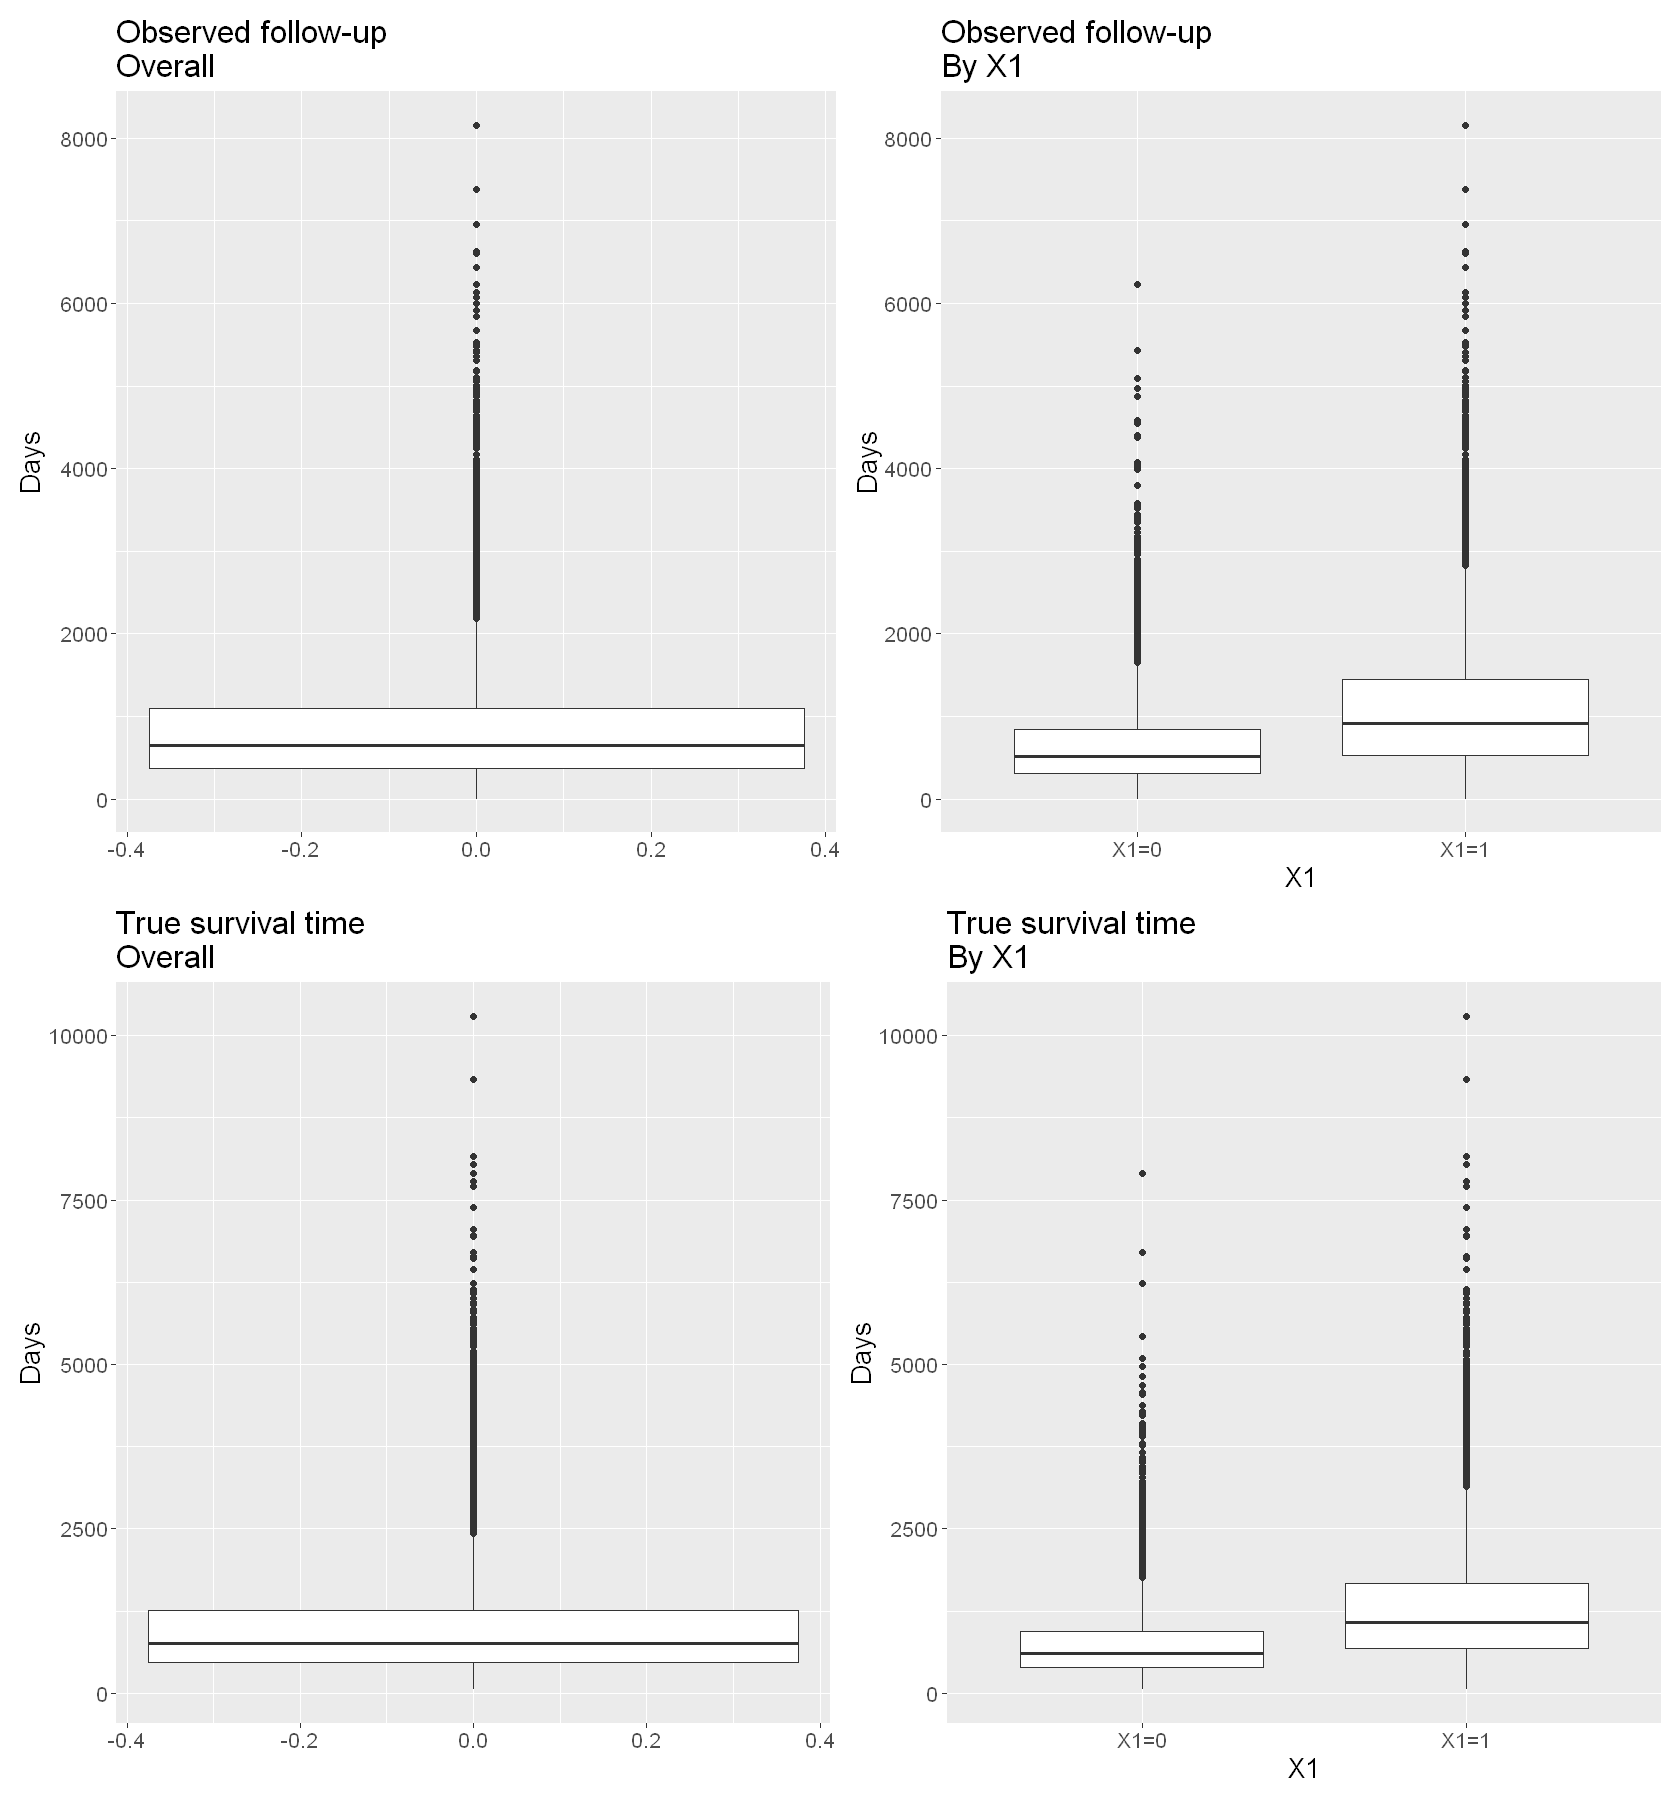

In [81]:
library(ggplot2)
library(patchwork)

options(repr.plot.width = 14, repr.plot.height = 15)

p <- (ggplot(df_eda, aes(y = followup_days)) +
        geom_boxplot() +
        labs(title = "Observed follow-up\nOverall", y = "Days", x = NULL) |
      ggplot(df_eda, aes(x = x1_fac, y = followup_days)) +
        geom_boxplot() +
        labs(title = "Observed follow-up\nBy X1", x = "X1", y = "Days")) /
     (ggplot(df_eda, aes(y = true_survival_days)) +
        geom_boxplot() +
        labs(title = "True survival time\nOverall", y = "Days", x = NULL) |
      ggplot(df_eda, aes(x = x1_fac, y = true_survival_days)) +
        geom_boxplot() +
        labs(title = "True survival time\nBy X1", x = "X1", y = "Days")) &
     theme(text = element_text(size = 16))
p

<!-- AUTO: commentary -->

**X2 eloszlas X1 szerint.** Atlapolt hisztogramon hasonlitja ossze X2 eloszlasat X1 csoportokban.
Ha az eloszlasok elternek, X1 es X2 kapcsolatban allhat, ami a tulelest es a prevalenciat is befolyasolja.


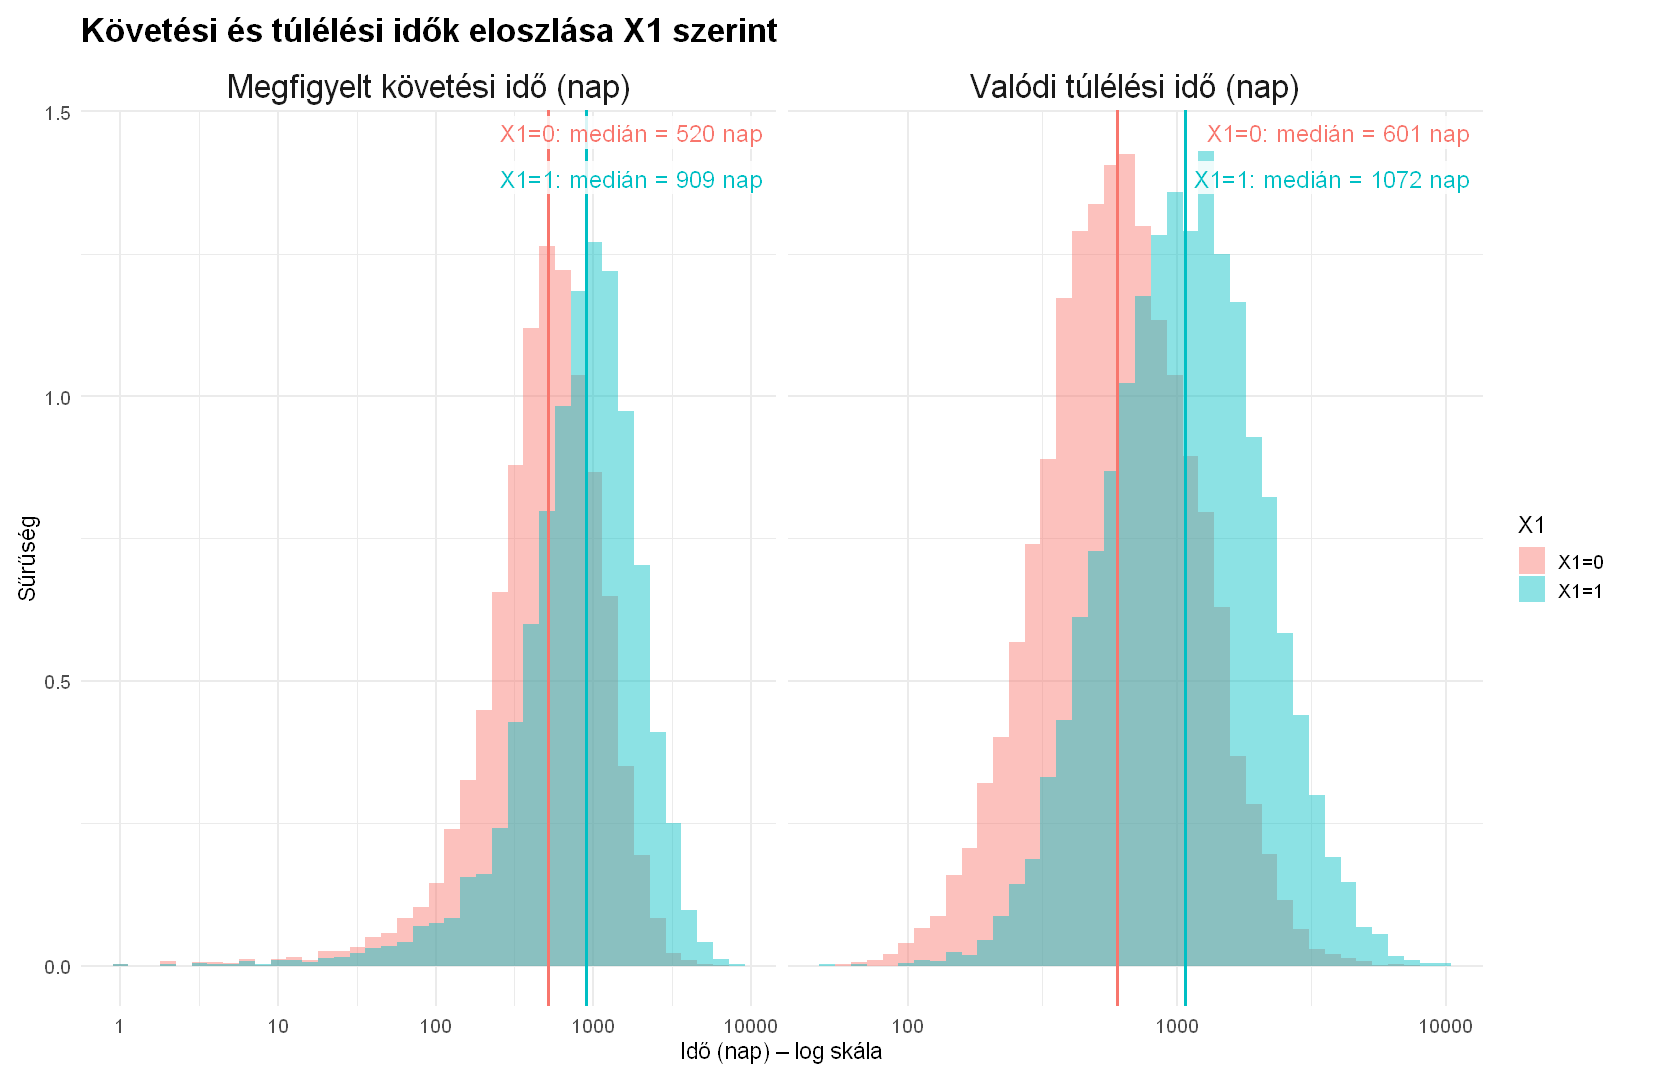

In [82]:
library(dplyr)
library(tidyr)
library(ggplot2)

options(repr.plot.width = 14, repr.plot.height = 9)

df_long <- df_eda %>%
  select(x1, followup_days, true_survival_days) %>%
  pivot_longer(c(followup_days, true_survival_days),
               names_to = "tipus", values_to = "nap")

df_long$x1 <- factor(df_long$x1, levels = c(0, 1), labels = c("X1=0", "X1=1"))
df_long$tipus <- ifelse(df_long$tipus == "followup_days",
                        "Megfigyelt követési idő (nap)",
                        "Valódi túlélési idő (nap)")
df_long <- df_long[is.finite(df_long$nap) & df_long$nap > 0, ]

med <- df_long %>%
  group_by(tipus, x1) %>%
  summarise(med = median(nap), .groups = "drop") %>%
  mutate(
    label = paste0(x1, ": medián = ", round(med, 0), " nap"),
    vj = ifelse(x1 == "X1=0", 1.2, 2.6)   # két sor egymás alatt
  )

ggplot(df_long, aes(x = nap, fill = x1)) +
  geom_histogram(aes(y = after_stat(density)),
                 bins = 40, position = "identity", alpha = 0.45) +
  geom_vline(data = med, aes(xintercept = med, color = x1),
             linewidth = 1.1, show.legend = FALSE) +
  geom_label(
    data = med,
    aes(x = Inf, y = Inf, label = label, color = x1, vjust = vj),
    inherit.aes = FALSE,
    hjust = 1.02,
    label.size = 0, fill = "white", alpha = 0.85, size = 5,
    show.legend = FALSE
  ) +
  facet_wrap(~ tipus, scales = "free_x") +
  scale_x_log10() +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(size = 20, face = "bold"),
    strip.text = element_text(size = 20),
    plot.margin = margin(10, 40, 10, 10)
  ) +
  labs(
    title = "Követési és túlélési idők eloszlása X1 szerint",
    x = "Idő (nap) – log skála",
    y = "Sűrűség",
    fill = "X1"
  )


In [83]:
table(df_long$tipus, df_long$x1)


                               
                                 X1=0  X1=1
  Megfigyelt követési idő (nap) 12247  8823
  Valódi túlélési idő (nap)     12252  8826

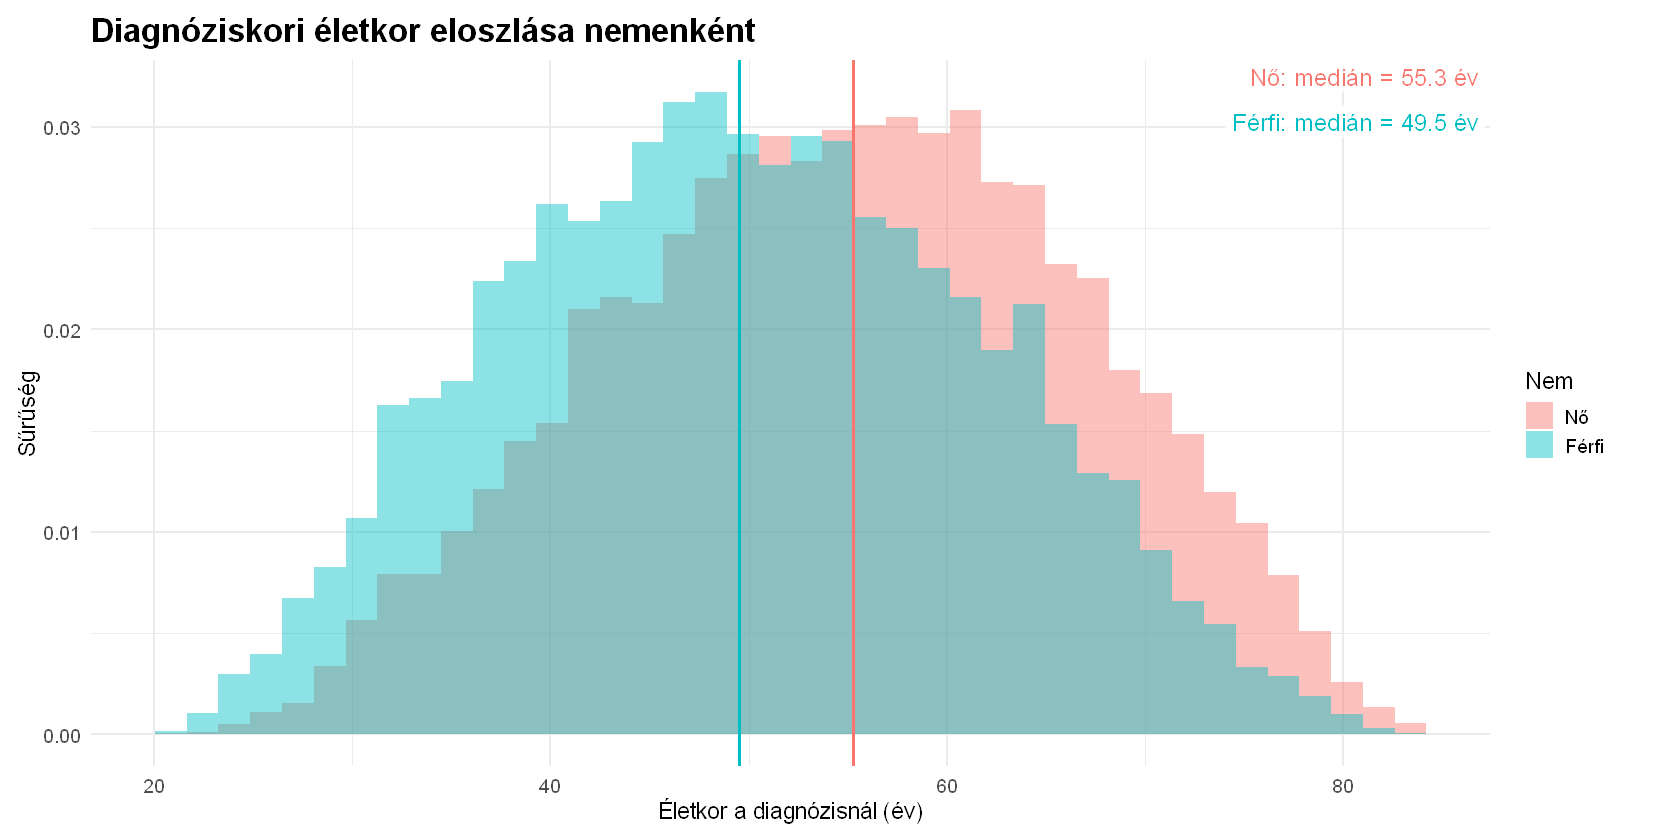

In [84]:
library(dplyr)
library(ggplot2)

age_col <- if ("age_at_dx" %in% names(df_eda)) {
  "age_at_dx"
} else if ("x2" %in% names(df_eda)) {
  "x2"
} else {
  "covariate_scaled_x2"
}

sex_vec <- if ("sex" %in% names(df_eda)) {
  df_eda$sex
} else if ("gender" %in% names(df_eda)) {
  df_eda$gender
} else if ("x1" %in% names(df_eda)) {
  df_eda$x1
} else if ("covariate_binary_x1" %in% names(df_eda)) {
  df_eda$covariate_binary_x1
} else {
  stop("Need sex/gender or x1 column for sex stratification.")
}

sex <- if (is.numeric(sex_vec) || is.integer(sex_vec)) {
  if (all(na.omit(unique(sex_vec)) %in% c(0, 1))) {
    factor(sex_vec, levels = c(0, 1), labels = c("Nő", "Férfi"))
  } else {
    factor(sex_vec)
  }
} else {
  factor(sex_vec)
}

df_plot <- df_eda %>%
  dplyr::transmute(age_at_dx = .data[[age_col]]) %>%
  dplyr::mutate(sex = sex) %>%
  dplyr::filter(is.finite(age_at_dx), !is.na(sex))

med <- df_plot %>%
  dplyr::group_by(sex) %>%
  dplyr::summarise(med = median(age_at_dx, na.rm = TRUE), .groups = "drop") %>%
  dplyr::arrange(sex) %>%
  dplyr::mutate(
    label = paste0(sex, ": medián = ", round(med, 1), " év"),
    vj = 1 + 1.4 * (dplyr::row_number() - 1)
  )

options(repr.plot.width = 14, repr.plot.height = 7)

ggplot(df_plot, aes(x = age_at_dx, fill = sex)) +
  geom_histogram(aes(y = after_stat(density)),
                 bins = 40, position = "identity", alpha = 0.45) +
  geom_vline(data = med, aes(xintercept = med, color = sex),
             linewidth = 1.1, show.legend = FALSE) +
  geom_label(
    data = med,
    aes(x = Inf, y = Inf, label = label, color = sex, vjust = vj),
    inherit.aes = FALSE,
    hjust = 1.02,
    label.size = 0, fill = "white", alpha = 0.85, size = 5,
    show.legend = FALSE
  ) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(size = 20, face = "bold"),
    plot.margin = margin(10, 40, 10, 10)
  ) +
  labs(
    title = "Diagnóziskori életkor eloszlása nemenként",
    x = "Életkor a diagnózisnál (év)",
    y = "Sűrűség",
    fill = "Nem"
  )


Életkor vs true survival days (szórás + trend)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


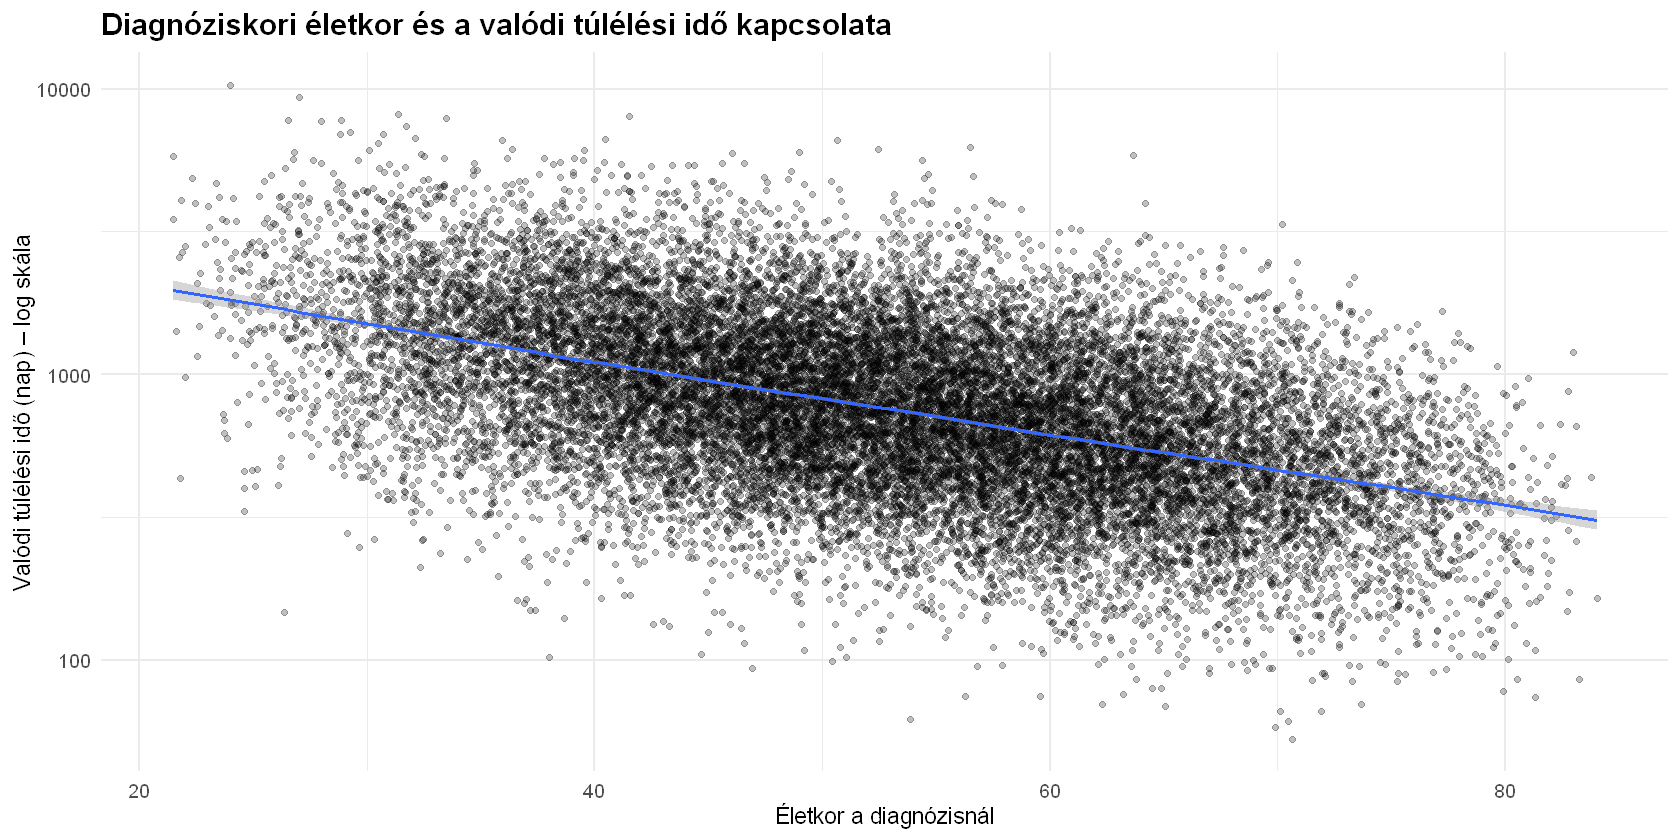

In [85]:
library(dplyr)
library(ggplot2)

age_col <- if ("age_at_dx" %in% names(df_eda)) "age_at_dx" else "x2"

if (!"true_survival_days" %in% names(df_eda)) {
  if (!all(c("true_event_date_F_true", "diagnosis_date_D") %in% names(df_eda))) {
    stop("Need true_survival_days or (true_event_date_F_true, diagnosis_date_D) columns in df_eda.")
  }
  df_eda$true_survival_days <- as.numeric(as.Date(df_eda$true_event_date_F_true) - as.Date(df_eda$diagnosis_date_D))
}

df_plot <- df_eda %>%
  dplyr::transmute(
    age = .data[[age_col]],
    true_survival_days = .data[["true_survival_days"]]
  ) %>%
  dplyr::filter(is.finite(age), is.finite(true_survival_days), true_survival_days > 0)

ggplot(df_plot, aes(x = age, y = true_survival_days)) +
  geom_point(alpha = 0.25) +
  geom_smooth(se = TRUE) +
  scale_y_log10() +
  labs(
    title = "Diagnóziskori életkor és a valódi túlélési idő kapcsolata",
    x = "Életkor a diagnózisnál",
    y = "Valódi túlélési idő (nap) – log skála"
  ) +
  theme_minimal(base_size = 14) +
  theme(plot.title = element_text(size = 18, face = "bold"))


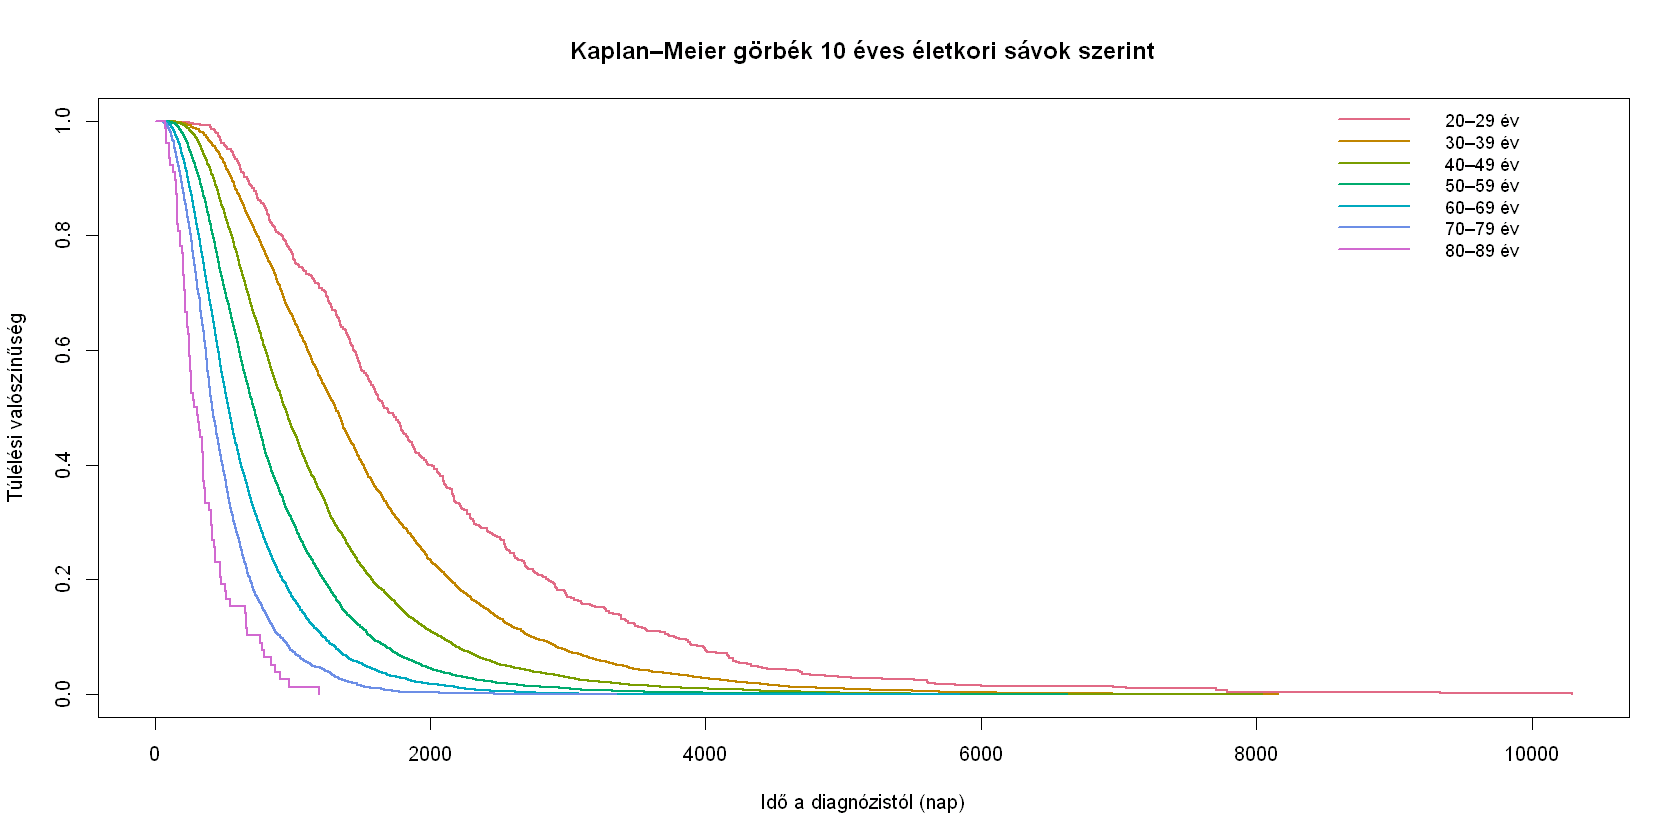

In [86]:
library(survival)

age_col <- if ("age_at_dx" %in% names(df_eda)) "age_at_dx" else "x2"

d <- df_eda[, c(age_col, "true_survival_days", "true_event_indicator_delta_true")]
colnames(d) <- c("age", "time", "event")
d <- d[is.finite(d$age) & is.finite(d$time) & d$time > 0 & !is.na(d$event), ]

# 10 éves sávok: [a,a+10)
a_min <- floor(min(d$age, na.rm = TRUE) / 10) * 10
a_max <- ceiling(max(d$age, na.rm = TRUE) / 10) * 10
breaks <- seq(a_min, a_max, by = 10)

labs <- paste0(breaks[-length(breaks)], "–", breaks[-1] - 1, " év")
d$age_band <- cut(d$age, breaks = breaks, right = FALSE, include.lowest = TRUE, labels = labs)

# KM illesztés
fit <- survfit(Surv(time, event) ~ age_band, data = d)

# színek (base R palette, automatikus)
cols <- grDevices::hcl.colors(nlevels(d$age_band), palette = "Dark 3")

plot(fit, col = cols, lwd = 2,
     xlab = "Idő a diagnózistól (nap)",
     ylab = "Túlélési valószínűség",
     main = "Kaplan–Meier görbék 10 éves életkori sávok szerint")
legend("topright", legend = levels(d$age_band), col = cols, lwd = 2, bty = "n", cex = 0.9)


<!-- AUTO: commentary -->

**Kapcsolatok.** Korrelaciokat es abraakat ad a follow-up ido es a kovariansok kapcsolataira, majd egy egyszeru linearis modellt illeszt.
Az elojel es hatasmeret jelzi, mely kovariansok roviditik vagy hosszabbitjak a megfigyelt idot.


  covariate   spearman    pearson
1        X1  0.3267294  0.2812036
2        X2 -0.4159361 -0.3662438
3        X3 -0.4338035 -0.3861760
            Estimate Std. Error  t value Pr(>|t|)
(Intercept)   7.4691     0.0263 284.4449        0
x1            0.5675     0.0115  49.1585        0
x2           -0.0160     0.0005 -33.1424        0
x3           -0.3032     0.0049 -61.6810        0


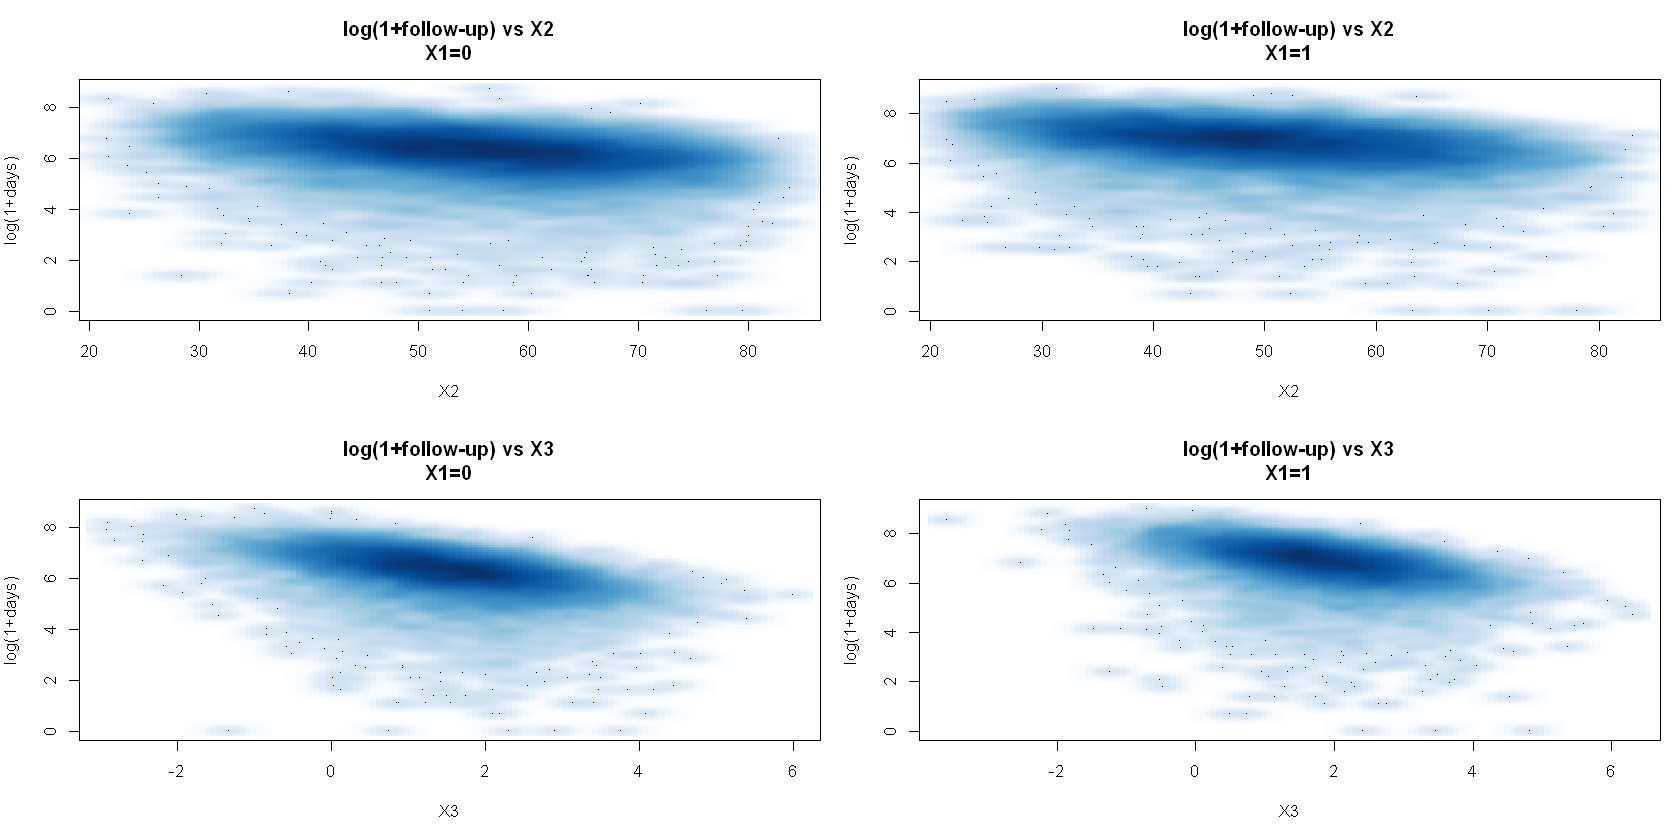

In [87]:
# --- EDA: Relationship between survival time and covariates ---
cor_tbl <- data.frame(
  covariate = c("X1", "X2", "X3"),
  spearman = c(
    cor(df_eda$log_followup_days, df_eda$x1, method = "spearman"),
    cor(df_eda$log_followup_days, df_eda$x2, method = "spearman"),
    cor(df_eda$log_followup_days, df_eda$x3, method = "spearman")
  ),
  pearson = c(
    cor(df_eda$log_followup_days, df_eda$x1, method = "pearson"),
    cor(df_eda$log_followup_days, df_eda$x2, method = "pearson"),
    cor(df_eda$log_followup_days, df_eda$x3, method = "pearson")
  )
)
print(cor_tbl)

op <- par(mfrow = c(2, 2), mar = c(5, 4, 4, 1))

smoothScatter(
  df_eda$x2[df_eda$x1 == 0],
  df_eda$log_followup_days[df_eda$x1 == 0],
  main = "log(1+follow-up) vs X2\nX1=0",
  xlab = "X2",
  ylab = "log(1+days)"
)

smoothScatter(
  df_eda$x2[df_eda$x1 == 1],
  df_eda$log_followup_days[df_eda$x1 == 1],
  main = "log(1+follow-up) vs X2\nX1=1",
  xlab = "X2",
  ylab = "log(1+days)"
)

smoothScatter(
  df_eda$x3[df_eda$x1 == 0],
  df_eda$log_followup_days[df_eda$x1 == 0],
  main = "log(1+follow-up) vs X3\nX1=0",
  xlab = "X3",
  ylab = "log(1+days)"
)

smoothScatter(
  df_eda$x3[df_eda$x1 == 1],
  df_eda$log_followup_days[df_eda$x1 == 1],
  main = "log(1+follow-up) vs X3\nX1=1",
  xlab = "X3",
  ylab = "log(1+days)"
)

par(op)

fit <- lm(log_followup_days ~ x1 + x2 + x3, data = df_eda)
print(round(summary(fit)$coefficients, 4))


<!-- AUTO: commentary -->

**Incidencia trendek.** Eves diagnozis esetszamokat szamol es abrazol (opcionalisan osszeveti a generator `yearly_incidence` attributumaval).
A trendnek kovetnie kell a parameterzett incidencia logikat; nagy elteres a generalas problemaja lehet.


   year n_cases
1  2000     906
2  2001     931
3  2002     927
4  2003     963
5  2004     885
6  2005     885
7  2006     872
8  2007     986
9  2008     979
10 2009     840


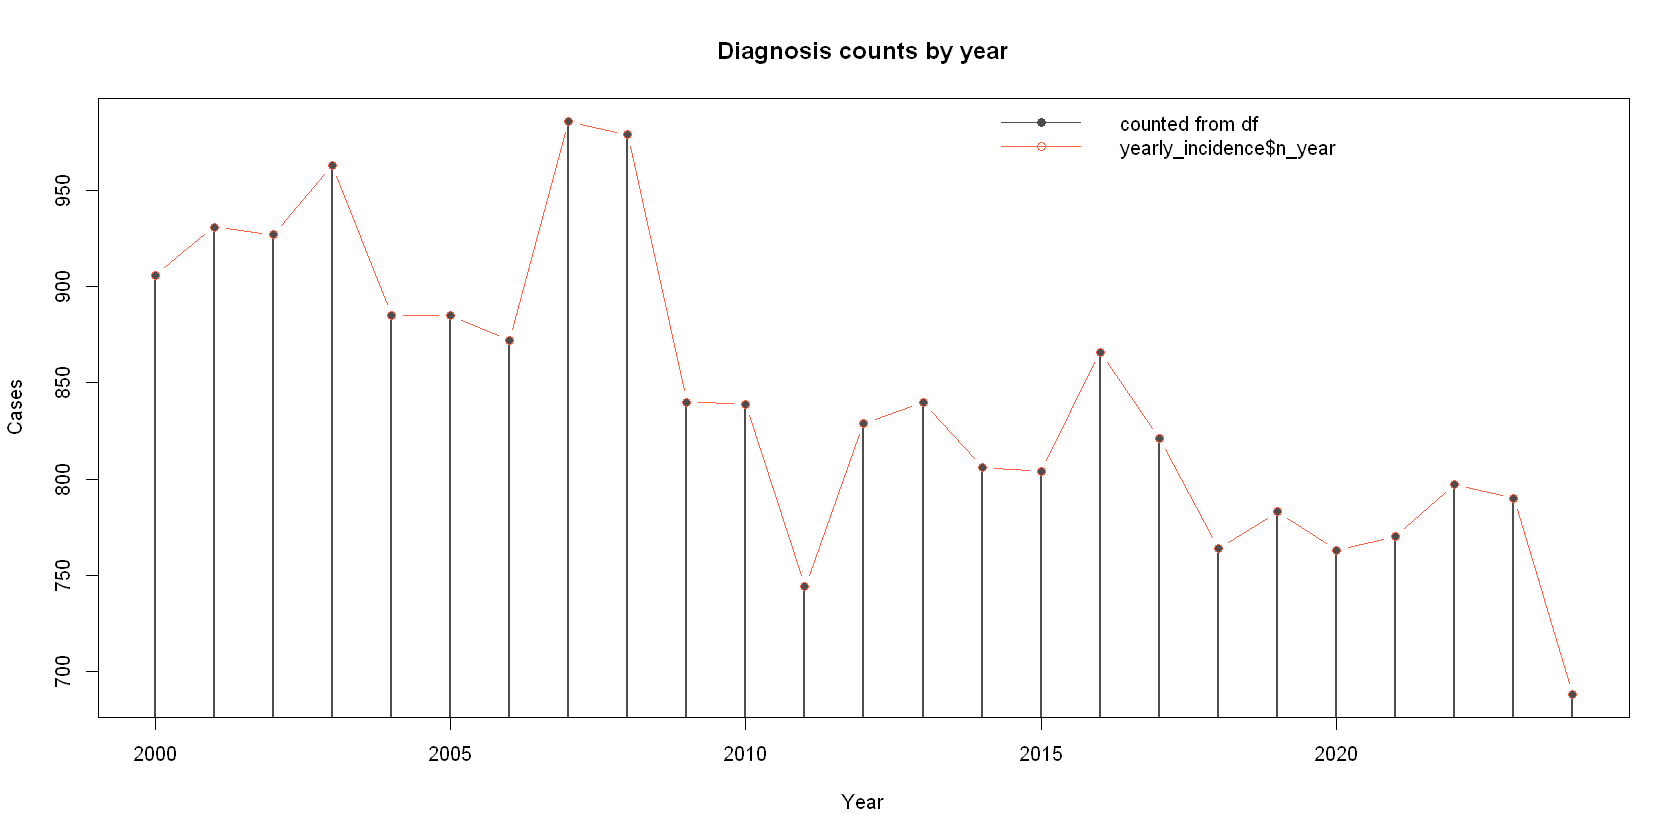

In [88]:
# --- EDA: Incidence (diagnosis counts) by calendar year ---

df_eda$diag_year <- as.integer(format(df_eda$diagnosis_date_D, "%Y"))
inc_counts <- as.data.frame(table(df_eda$diag_year))
colnames(inc_counts) <- c("year", "n_cases")
inc_counts$year <- as.integer(as.character(inc_counts$year))
inc_counts$n_cases <- as.integer(inc_counts$n_cases)

inc_counts <- inc_counts[order(inc_counts$year), ]
print(head(inc_counts, 10))

plot(
  inc_counts$year,
  inc_counts$n_cases,
  type = "h",
  lwd = 2,
  col = "grey30",
  main = "Diagnosis counts by year",
  xlab = "Year",
  ylab = "Cases"
)

points(inc_counts$year, inc_counts$n_cases, pch = 16, col = "grey30")

yi <- attr(synthetic_registry, "yearly_incidence")
if (!is.null(yi) && all(c("year", "n_year") %in% names(yi))) {
  lines(yi$year, yi$n_year, type = "b", pch = 1, col = "tomato")
  legend("topright", legend = c("counted from df", "yearly_incidence$n_year"), col = c("grey30", "tomato"), lty = c(1, 1), pch = c(16, 1), bty = "n")
}


<!-- AUTO: commentary -->

**Prevalencia (tobb indexdatum).** Tobbb indexdatumra szamolja a prevalens esetszamot `true_F` es `observed_F` alapon, es `population_size` megadasa eseten a ratat is.
Az `observed_F` tipikusan alacsonyabb a cenzoralas miatt; a kulonbseg adja a korrigalandot.


In [89]:
index_date <- as.Date(c(
  "2000-01-01",
  "2010-01-01",
  "2015-01-01",
  "2014-01-01",
  "2015-01-01",
  "2016-01-01",
  "2017-01-01",
  "2018-01-01"
))

population_size <- 10e3

prevalence_summary <- count_prevalence_at_index(
  synthetic_registry,
  index_date = index_date,
  population_size = population_size,
  include_index_day = FALSE
)

print(prevalence_summary, row.names = FALSE)


 index_date followup_basis prevalent_cases diagnosed_cases prevalence_rate
 2000-01-01         true_F               2               2          0.0002
 2000-01-01     observed_F               2               2          0.0002
 2010-01-01         true_F            2450            9176          0.2450
 2010-01-01     observed_F            2152            9176          0.2152
 2015-01-01         true_F            2225           13234          0.2225
 2015-01-01     observed_F            1961           13234          0.1961
 2014-01-01         true_F            2230           12427          0.2230
 2014-01-01     observed_F            1953           12427          0.1953
 2015-01-01         true_F            2225           13234          0.2225
 2015-01-01     observed_F            1961           13234          0.1961
 2016-01-01         true_F            2196           14038          0.2196
 2016-01-01     observed_F            1940           14038          0.1940
 2017-01-01         true_

                   true_survival_days     x1     x2     x3
true_survival_days              1.000  0.393 -0.490 -0.518
x1                              0.393  1.000 -0.203  0.146
x2                             -0.490 -0.203  1.000  0.261
x3                             -0.518  0.146  0.261  1.000


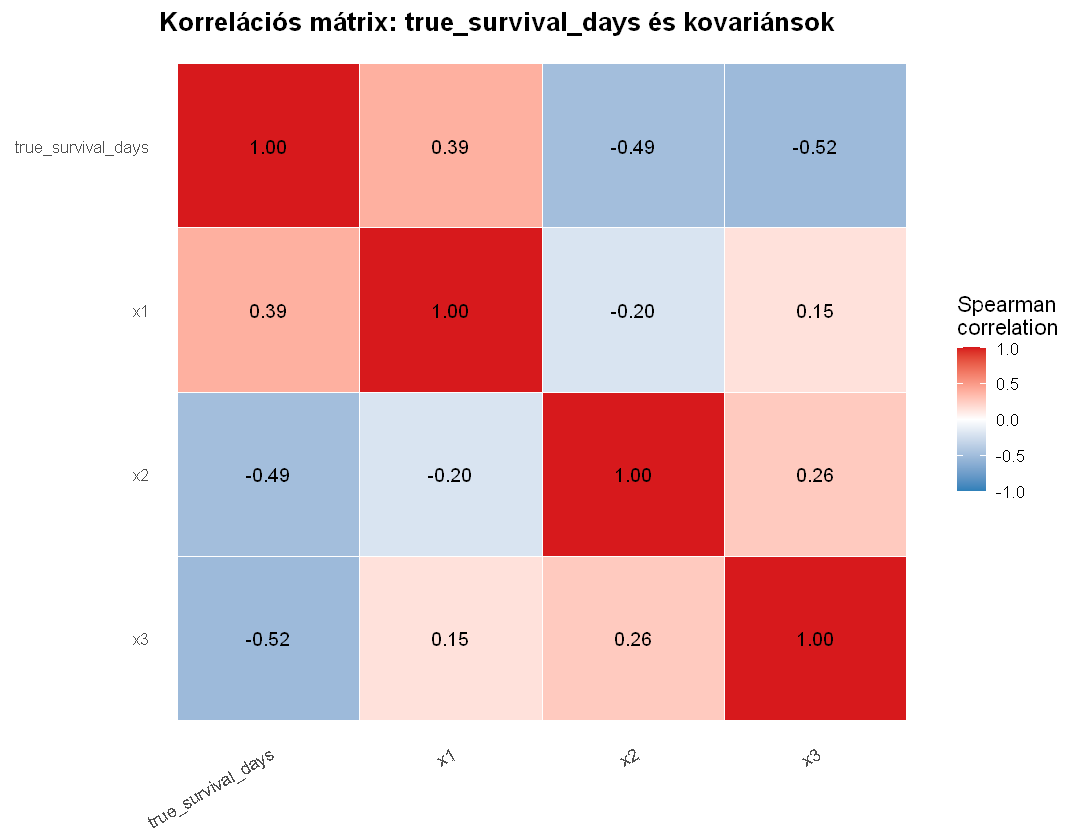

In [90]:
library(dplyr)
library(tidyr)
library(ggplot2)

if (!"true_survival_days" %in% names(df_eda)) {
  if (!all(c("true_event_date_F_true", "diagnosis_date_D") %in% names(df_eda))) {
    stop("Need true_survival_days or (true_event_date_F_true, diagnosis_date_D) columns in df_eda.")
  }
  df_eda$true_survival_days <- as.numeric(as.Date(df_eda$true_event_date_F_true) - as.Date(df_eda$diagnosis_date_D))
}

corr_df <- df_eda %>%
  dplyr::select(true_survival_days, x1, x2, x3) %>%
  dplyr::mutate(dplyr::across(dplyr::everything(), as.numeric))

corr_matrix <- cor(corr_df, use = "complete.obs", method = "spearman")
print(round(corr_matrix, 3))

corr_long <- as.data.frame(as.table(corr_matrix))
names(corr_long) <- c("var_row", "var_col", "corr")
corr_long$var_row <- factor(corr_long$var_row, levels = rev(colnames(corr_matrix)))
corr_long$var_col <- factor(corr_long$var_col, levels = colnames(corr_matrix))

options(repr.plot.width = 9, repr.plot.height = 7)

ggplot(corr_long, aes(x = var_col, y = var_row, fill = corr)) +
  geom_tile(color = "white", linewidth = 0.4) +
  geom_text(aes(label = sprintf("%.2f", corr)), size = 4) +
  scale_fill_gradient2(
    low = "#2c7fb8", mid = "white", high = "#d7191c",
    midpoint = 0, limits = c(-1, 1), name = "Spearman\ncorrelation"
  ) +
  labs(
    title = "Korrelációs mátrix: true_survival_days és kovariánsok",
    x = NULL,
    y = NULL
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.x = element_text(angle = 30, hjust = 1),
    panel.grid = element_blank(),
    plot.title = element_text(face = "bold")
  )

Kovariánsok summary statistics			
Incidenskori életkor historram <nemenként>			
Túlélési idők summary statistics			
Túlélési idők histogram			
Túlélési görbék életkori sávonként			
Túlélési idő és kovariánsok korrelációi			
Incidenciatrendek			
Incidens populácó életkori elozlása <overlap> prevalens populáció életkori eloszlása			
Cenzorálásra valami, hogy lássuk, hogy nem informatív			
    X_1 kénti megoszlás		
    X_2 életkori sávonként a cenzoráltak aránya		
    X_3 sávonként a cenzoráltak aránya		
mekkora alulbecslést okoz LTFU a ground truth-hoz képest.			
mennyire áll meg az ha indexdátumon az LTFU eseteket élőnek veszem, ahogy az rprev feltételezi			
    True és cenzred=1 szumma közötti különbség változása különböző indexdátumokon.		
            
Regisztráció előtt diagnosztizált esetek hatása a prevalenciára évenként ahogy távolodunk a regiszter kezdetétől.			
    Milyen összefüggést mutat ez az átlagos, és a maximális túlélési időkkel		


Beállítások:			
Incidencia			
params$inc_lam0  <- 850     # maradhat, vagy finoman állíthatod			
params$inc_g     <- -0.01   # ~1% csökkenés évente (enyhe)			
params$inc_sdlog <- 0.08    # enyhe paraméterbizonytalanság (stabilabb)			
            
        Idősek esetén nagyobb incidencia	
        Idősek esetén rövidebb túlélési idő	
            Negatív korreláció az életkorral megvalósul
